## FewShot RAG Agent



In [ ]:
#| hide
%load_ext autoreload
%autoreload 2


In [ ]:
# | hide
from ladle.core import get_git_root, load_env, checkLogs, json_render

load_env()

True

In [ ]:
from pathlib import Path
from pprint import pprint

from ladle.diagrams import (
    Define,Scope,
    V,E,
    draw_diagram
)
from ladle.chat import Chat
from ladle.std import Condition as C
from ladle.db import ChromaClient


In [ ]:
chorma_client = ChromaClient()

In [ ]:
dog_docs = [
    {
        'id': 'dog1',
        'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
        'metadata': {'breed': 'Golden Retriever'}
    },
    {
        'id': 'dog2', 
        'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
        'metadata': {'breed': 'German Shepherd'}
    },
    {
        'id': 'dog3',
        'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
        'metadata': {'breed': 'Golden Retriever'}  # Near duplicate of dog1
    },
    {
        'id': 'dog4',
        'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
        'metadata': {'breed': 'Husky'}
    },
    {
        'id': 'dog5',
        'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
        'metadata': {'breed': 'Husky'}  # Near duplicate of dog4
    }
]

# Add documents to index
chorma_client.add_collection("dog_docs",exists_ok=True)
chorma_client.upsert(collection_name="dog_docs",docs=dog_docs)

[{'id': 'dog1',
  'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
  'metadata': {'breed': 'Golden Retriever'}},
 {'id': 'dog2',
  'text': 'German Shepherds are loyal, protective dogs often used in police work. They are highly trainable and good at various tasks.',
  'metadata': {'breed': 'German Shepherd'}},
 {'id': 'dog3',
  'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
  'metadata': {'breed': 'Golden Retriever'}},
 {'id': 'dog4',
  'text': 'Huskies are energetic working dogs bred for cold climates. They have thick fur and often blue eyes.',
  'metadata': {'breed': 'Husky'}},
 {'id': 'dog5',
  'text': 'Siberian Huskies are active working dogs that thrive in cold weather. They are known for their thick coats and striking blue eyes.',
  'metadata': {'breed': 'Husky'}}]

In [ ]:
# Query about golden retrievers
query = "Tell me about golden retrievers as family pets"

# Get similar documents
results = chorma_client.query(collection_name="dog_docs",query=query,k=2)
results


[{'id': 'dog1',
  'text': 'The Golden Retriever is a friendly, intelligent breed known for its golden coat. They make excellent family pets and are great with children.',
  'metadata': {'breed': 'Golden Retriever'},
  'distance': 0.6284635066986084},
 {'id': 'dog3',
  'text': 'The Golden Retriever is a friendly, intelligent breed with a beautiful golden coat. They are wonderful family pets that get along well with kids.',
  'metadata': {'breed': 'Golden Retriever'},
  'distance': 0.6371400952339172}]

In [ ]:
rag_prompt = [
            {'role':'system','content':'''
            You are a helpful assistant that answers questions about dogs.

            Here are some examples of how to answer questions about dogs:
            {% for example in examples %}
            Question: {{example['question']}}
            Answer: {{example['answer']}}
            {% endfor %}

            I found the following documents that may be relevant to the user's question:
            {% for doc in docs %}
            {{doc['text']}}
            {% endfor %}
            '''},
            {'role':'user','content':'{{input}}'},
            ]

style_examples = [
    {
        'question': "What are the key traits of Pandas?",
        'answer': """Here are the key traits of Pandas:
            • Pandas are a type of bear
            • They are native to South America
            • They are known for their black and white fur
            • They are known for their love of bamboo"""
    },
    {
        'question': "What are the key traits of Lions?",
        'answer': """Here are the key traits of Lions:
            • Lions are a type of bear
            • They are native to Africa
            • They are known for their mane of hair"""
    }
]

pprint(json_render(rag_prompt,context={
    'docs':results,
    'input':"Tell me about golden retrievers as family pets",
    'examples':style_examples
    }))

[{'content': 'You are a helpful assistant that answers questions about dogs.\n'
             '\n'
             'Here are some examples of how to answer questions about dogs:\n'
             '\n'
             'Question: What are the key traits of Pandas?\n'
             'Answer: Here are the key traits of Pandas:\n'
             '• Pandas are a type of bear\n'
             '• They are native to South America\n'
             '• They are known for their black and white fur\n'
             '• They are known for their love of bamboo\n'
             '\n'
             'Question: What are the key traits of Lions?\n'
             'Answer: Here are the key traits of Lions:\n'
             '• Lions are a type of bear\n'
             '• They are native to Africa\n'
             '• They are known for their mane of hair\n'
             '\n'
             '\n'
             'I found the following documents that may be relevant to the '
             "user's question:\n"
             '\n'
             'T

In [ ]:
rag_chat = Chat(model='gpt-4o-mini',messages=rag_prompt,examples=style_examples)

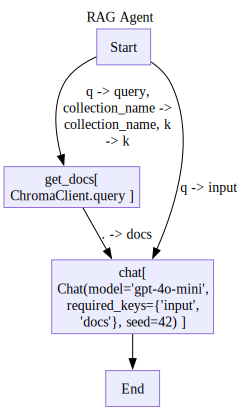

In [ ]:
with Define('RAG Agent',type='flow') as RAG:
    V('get_docs',chorma_client.query,
        inputs=['Start(query=q,collection_name=collection_name,k=k)'],
    )
    V('chat',rag_chat,
        inputs=['get_docs(docs)','Start(input=q)'],
        outputs=['End']
    )
    

In [ ]:
d = RAG()
for trace in d.run({'q':'tell me some stuff about golden retrievers','collection_name':'dog_docs','k':2}):
    # trace.pprint()
    pass

pprint(d.output)


{'content': 'Here are some key traits of Golden Retrievers: They are a '
            'friendly and intelligent breed, known for their beautiful golden '
            'coat. They make excellent family pets and are great with '
            'children.',
 'meta': {'input_tokens': 315, 'output_tokens': 44},
 'role': 'assistant'}
